# PyTorch Model Deployment: EffNetB2 vs ViT Feature Extractors

In this lab, we will learn about machine learning model deployment concepts, create feature extractor models using EfficientNetB2 and Vision Transformer (ViT), and compare them to determine the best model for deployment.

## Learning Objectives

By the end of this lab, you will be able to:
- Understand what model deployment means and why it's important
- Create an EffNetB2 feature extractor model using transfer learning
- Create a ViT (Vision Transformer) feature extractor model
- Train both models on food classification data
- Make predictions and time model inference speed
- Compare models across accuracy, speed, and size metrics
- Visualize the speed vs. performance tradeoff
- Decide which model to deploy based on deployment constraints

## 0. Getting setup 

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll define the helper functions (such as `create_dataloaders()`, `train()`, `save_model()`, etc.) directly in this notebook for ease of use and understanding. These functions were originally created in PyTorch Going Modular

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision` v0.13 package (available as of July 2022), we'll make sure we've got the latest versions.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.9.1+cpu
torchvision version: 0.24.1+cpu



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


> **Note:** If you're using Google Colab and the cell above starts to install various software packages, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports and setting up device agnostic code.

We'll also define several helper functions directly in this notebook:
* `set_seeds()` to set the random seeds .
* `download_data()` to download a data source given a link .
* `plot_loss_curves()` to inspect our model's training results 
* `create_dataloaders()` to create training and testing DataLoaders 
* `train_step()`, `test_step()`, and `train()` for model training 
* `save_model()` to save trained models 

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import requests
import zipfile

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int = NUM_WORKERS
) -> Tuple[DataLoader, DataLoader, List[str]]:

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
        "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

print("[INFO] All helper functions defined successfully!")

[INFO] All helper functions defined successfully!


f:\poridhi-ai-labs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finally, we'll setup device-agnostic code to make sure our models run on the GPU.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Getting data

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the 20% pizza, steak and sushi dataset and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples (one model trained on a dataset to another model trained on the same dataset).



In [ ]:
data_20_percent_path = download_data(
    source="https://raw.githubusercontent.com/poridhioss/Introduction-to-Deep-Learning-with-Pytorch-Resources/main/Model-deployment/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent"
)

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

Wonderful!

Now we've got a dataset, let's create training and test paths.

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

The ideal deployed model FoodVision Mini performs well and fast. 

We'd like our model to perform as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about how fast the human eye can see

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

Of course, higher accuracy would be nice but this might sacrifice speed.

So our goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).


*FoodVision Mini deployment goals. We'd like a fast predicting well-performing model (because a slow app is boring).*

We'll put an emphasis on speed, meaning, we'd prefer a model performing at 90%+ accuracy at ~30FPS than a model performing 95%+ accuracy at 10FPS.

To try and achieve these results, let's bring in our best performing models from the previous sections: 

1. **EffNetB2 feature extractor** (EffNetB2 for short)
2. **ViT-B/16 feature extractor** (ViT for short)
    * **Note** ViT-B/16 stands for "Vision Transformer Base, patch size 16".

## 3. Creating an EffNetB2 feature extractor

We first created an EffNetB2 feature extractor model in PyTorch Experiment Tracking section 7.5.

And by the end of that section we saw it performed very well.

So let's now recreate it here so we can compare its results to a ViT feature extractor trained on the same data.

To do so we can:
1. Setup the pretrained weights as `weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT`, where "`DEFAULT`" means "best currently available" (or could use `weights="DEFAULT"`). 
2. Get the pretrained model image transforms from the weights with the `transforms()` method (we need these so we can convert our images into the same format as the pretrained EffNetB2 was trained on).
3. Create a pretrained model instance by passing the weights to an instance of `torchvision.models.efficientnet_b2`.
4. Freeze the base layers in the model.
5. Update the classifier head to suit our own data.

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Now to change the classifier head, let's first inspect it using the `classifier` attribute of our model.

In [7]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

Excellent! To change the classifier head to suit our own problem, let's replace the `out_features` variable with the same number of classes we have (in our case, `out_features=3`, one for pizza, steak, sushi).

> **Note:** This process of changing the output layers/classifier head will be dependent on the problem you're working on. For example, if you wanted a different *number* of outputs or a different *kind* of output, you would have to change the output layers accordingly. 

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

Beautiful!

### 3.1 Creating a function to make an EffNetB2 feature extractor
Looks like our EffNetB2 feature extractor is ready to go, however, since there's quite a few steps involved here, how about we turn the code above into a function we can re-use later?

We'll call it `create_effnetb2_model()` and it'll take a customizable number of classes and a random seed parameter for reproducibility.

Ideally, it will return an EffNetB2 feature extractor along with its associated transforms.

In [9]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Woohoo! That's a nice looking function, let's try it out.

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

No errors, nice, now to really try it out, let's get a summary with `torchinfo.summary()`. 

In [11]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])



Base layers frozen, top layers trainable and customized!

### 3.2 Creating DataLoaders for EffNetB2 

Our EffNetB2 feature extractor is ready, time to create some `DataLoader`s.

We can do this by using the `create_dataloaders()` function we defined earlier in this notebook.

We'll use a `batch_size` of 32 and transform our images using the `effnetb2_transforms` so they're in the same format that our `effnetb2` model was trained on.

In [12]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

### 3.3 Training EffNetB2 feature extractor

Model ready, `DataLoader`s ready, let's train!

Just like in PyTorch Experiment Tracking, ten epochs should be enough to get good results.

We can do so by creating an optimizer , a loss function and then passing these as well as our `DataLoader`s to the `train()` function we defined earlier in this notebook.

In [13]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = train(model=effnetb2,
                         train_dataloader=train_dataloader_effnetb2,
                         test_dataloader=test_dataloader_effnetb2,
                         epochs=10,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]f:\poridhi-ai-labs\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [00:59<08:54, 59.44s/it]

Epoch: 1 | train_loss: 0.9877 | train_acc: 0.5729 | test_loss: 0.7434 | test_acc: 0.9284


 20%|██        | 2/10 [01:58<07:55, 59.39s/it]

Epoch: 2 | train_loss: 0.7031 | train_acc: 0.8854 | test_loss: 0.5845 | test_acc: 0.9409


 30%|███       | 3/10 [02:56<06:51, 58.80s/it]

Epoch: 3 | train_loss: 0.5907 | train_acc: 0.8187 | test_loss: 0.4750 | test_acc: 0.9347


 40%|████      | 4/10 [03:55<05:52, 58.76s/it]

Epoch: 4 | train_loss: 0.4885 | train_acc: 0.8729 | test_loss: 0.4018 | test_acc: 0.9409


 50%|█████     | 5/10 [04:58<05:01, 60.32s/it]

Epoch: 5 | train_loss: 0.4122 | train_acc: 0.9271 | test_loss: 0.3759 | test_acc: 0.9659


 60%|██████    | 6/10 [05:57<03:59, 59.79s/it]

Epoch: 6 | train_loss: 0.4277 | train_acc: 0.8875 | test_loss: 0.3498 | test_acc: 0.9659


 70%|███████   | 7/10 [06:56<02:58, 59.54s/it]

Epoch: 7 | train_loss: 0.3927 | train_acc: 0.8792 | test_loss: 0.3230 | test_acc: 0.9347


 80%|████████  | 8/10 [07:55<01:58, 59.41s/it]

Epoch: 8 | train_loss: 0.3267 | train_acc: 0.8896 | test_loss: 0.3115 | test_acc: 0.9437


 90%|█████████ | 9/10 [08:55<00:59, 59.56s/it]

Epoch: 9 | train_loss: 0.3139 | train_acc: 0.9083 | test_loss: 0.3006 | test_acc: 0.9563


100%|██████████| 10/10 [09:56<00:00, 59.66s/it]

Epoch: 10 | train_loss: 0.2874 | train_acc: 0.9396 | test_loss: 0.2657 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves 

Nice!

Let's turn its results into loss curves to inspect them further.

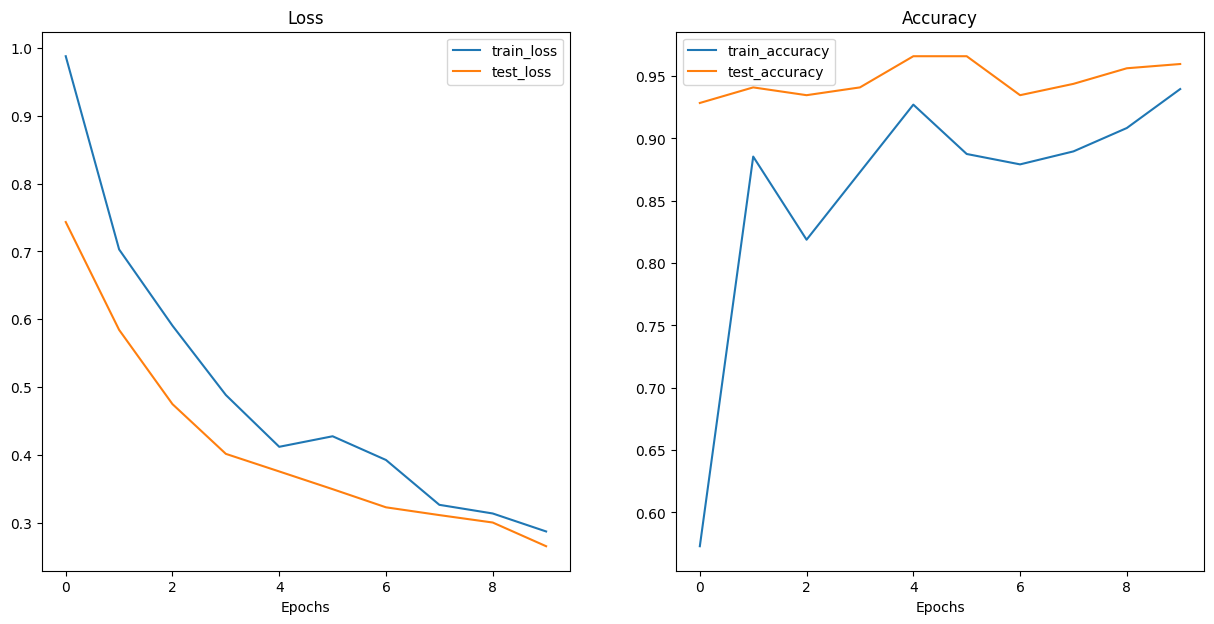

In [14]:
plot_loss_curves(effnetb2_results)

Woah!

Those are some nice looking loss curves. 

It looks like our model is performing quite well and perhaps would benefit from a little longer training and potentially some data augmentation.

### 3.5 Saving EffNetB2 feature extractor

Now we've got a well-performing trained model, let's save it to file so we can import and use it later.

To save our model we can use the `save_model()` function we defined earlier in this notebook.

We'll set the `target_dir` to `"models"` and the `model_name` to `"09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"` (a little comprehensive but at least we know what's going on).

In [15]:
save_model(model=effnetb2, target_dir="models",
           model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of EffNetB2 feature extractor

Since one of our criteria for deploying a model to power FoodVision Mini is **speed** (~30FPS or better), let's check the size of our model.

Why check the size?

Well, while not always the case, the size of a model can influence its inference speed.

As in, if a model has more parameters, it generally performs more operations and each one of these operations requires some computing power.

And because we'd like our model to work on devices with limited computing power (e.g. on a mobile device or in a web browser), generally, the smaller the size the better (as long as it still performs well in terms of accuracy).

To check our model's size in bytes, we can use Python's `pathlib.Path.stat("path_to_model").st_size` and then we can convert it (roughly) to megabytes by dividing it by `(1024*1024)`. 

In [16]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats

We've got a few statistics about our EffNetB2 feature extractor model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

And we'll calculate an extra one for fun, total number of parameters.

We can do so by counting the number of elements (or patterns/weights) in `effnetb2.parameters()`. We'll access the number of elements in each parameter using the `torch.numel()` method. 

In [17]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

Excellent!

Now let's put everything in a dictionary so we can make comparisons later on.

In [18]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2656757295131683,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Looks like our EffNetB2 model is performing at over 95% accuracy! 

Criteria number 1: perform at 95%+ accuracy - check!

Now let's create a ViT model and compare the two.

## 4. Creating a ViT Feature Extractor

Time to continue with our FoodVision Mini modelling experiments.

This time we're going to create a ViT (Vision Transformer) feature extractor.

And we'll do it in much the same way as the EffNetB2 feature extractor except this time with `torchvision.models.vit_b_16()` instead of `torchvision.models.efficientnet_b2()`.

We'll start by creating a function called `create_vit_model()` which will be very similar to `create_effnetb2_model()` except of course returning a ViT feature extractor model and transforms rather than EffNetB2.

One slight difference is that `torchvision.models.vit_b_16()`'s output layer is called `heads` rather than `classifier`.

In [ ]:
vit_temp = torchvision.models.vit_b_16()
vit_temp.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

Notice the output layer is called `heads` and outputs 1000 features (for 1000 ImageNet classes). We'll need to change this to 3 for our pizza, steak, sushi classes.

Let's create a function to build our ViT feature extractor.

In [20]:
def create_vit_model(num_classes: int = 3, seed: int = 42):

    # 1. Get pretrained weights and transforms
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    
    # 2. Create model with pretrained weights
    model = torchvision.models.vit_b_16(weights=weights)

    # 3. Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # 4. Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768,  # keep this the same as original model
                  out_features=num_classes)  # update to reflect target number of classes
    )
    
    return model, transforms

ViT feature extraction model creation function ready! Let's test it out.

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)

No errors! Now let's get a nice-looking summary of our ViT model using `torchinfo.summary()`.

Just like our EffNetB2 feature extractor model, our ViT model's base layers are frozen and the output layer is customized to our needs! 

Do you notice the big difference though?

Our ViT model has *far* more parameters than our EffNetB2 model (~85M vs ~7.7M). Perhaps this will come into play when we compare our models across speed and performance later on.

### 4.1 Create DataLoaders for ViT

We've got our ViT model ready, now let's create some `DataLoader`s for it.

We'll do this in the same way we did for EffNetB2 except we'll use `vit_transforms` to transform our images into the same format the ViT model was trained on.

In [ ]:
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### 4.2 Training ViT feature extractor

Let's train our ViT feature extractor model for 10 epochs using our `train()` function with `torch.optim.Adam()` and a learning rate of `1e-3` as our optimizer and `torch.nn.CrossEntropyLoss()` as our loss function.

We'll use our `set_seeds()` function before training to try and make our results as reproducible as possible.

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = train(model=vit,
                    train_dataloader=train_dataloader_vit,
                    test_dataloader=test_dataloader_vit,
                    epochs=10,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

 10%|█         | 1/10 [02:17<20:33, 137.00s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [04:40<18:45, 140.74s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [06:56<16:11, 138.74s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [09:11<13:43, 137.22s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [11:29<11:27, 137.52s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [13:43<09:05, 136.42s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [16:04<06:53, 137.72s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [18:23<04:36, 138.09s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [20:47<02:20, 140.11s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [23:03<00:00, 138.35s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

Let's visualize the loss curves to see how our ViT model learned.

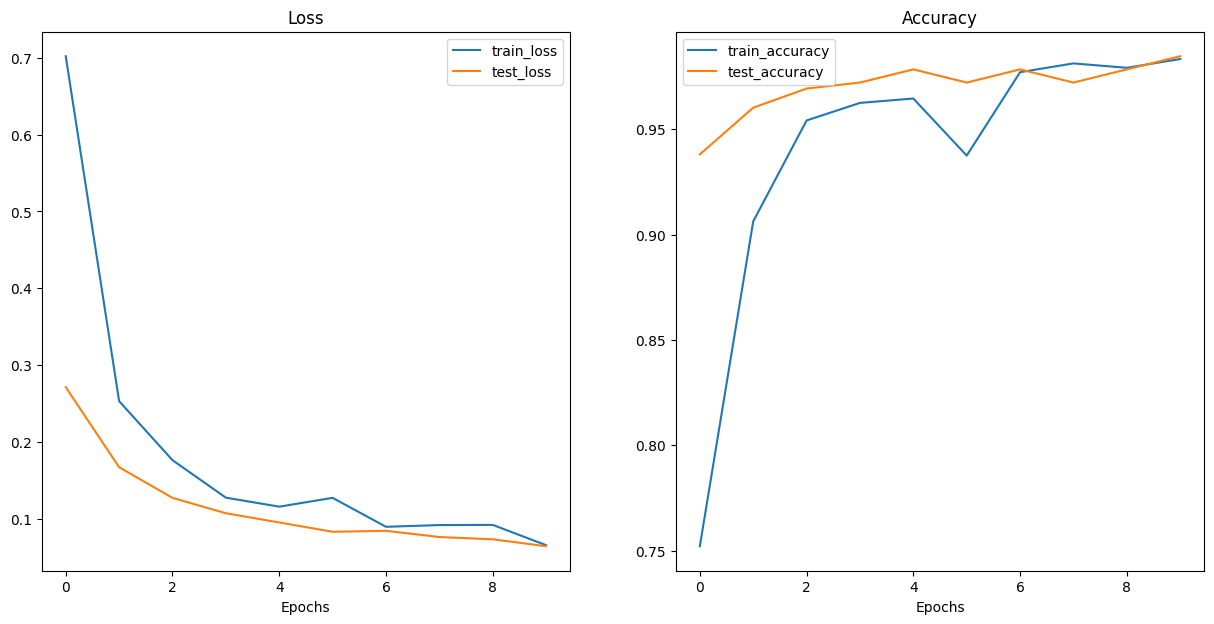

In [24]:
plot_loss_curves(vit_results)

Nice looking loss curves! Just like our EffNetB2 model, it looks like the ViT model might benefit from longer training and some data augmentation.

### 4.4 Saving ViT feature extractor

Let's save our trained ViT model to file.

In [ ]:
save_model(model=vit, target_dir="models",
           model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

Let's check the model size in megabytes.

In [ ]:
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats

Let's count the total parameters and collect all stats in a dictionary.

In [ ]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
print(f"ViT total parameters: {vit_total_params:,}")

vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "number_of_parameters": vit_total_params,
    "model_size (MB)": pretrained_vit_model_size
}
vit_stats

ViT total parameters: 85,800,963


{'test_loss': 0.06443444732576609,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making Predictions and Timing Them

We've got two trained models, both performing well. Now let's test how fast they make predictions.

We know both models perform at over 95% accuracy, but how fast are they?

Ideally, for deploying FoodVision Mini to a mobile device, we'd like predictions to happen at real-time (~30 FPS or 0.03 seconds per image).

Let's create a function to make predictions and time them.

In [ ]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Found {len(test_data_paths)} test images")
test_data_paths[:5]

Found 150 test images


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

### 5.1 Creating a function to make predictions and time them

Let's create a `pred_and_store()` function that iterates over test images, makes predictions, and times how long each takes.

In [ ]:
import pathlib
from PIL import Image
from timeit import default_timer as timer

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms.Compose, 
                   class_names: List[str], 
                   device: str = "cpu") -> List[Dict]:

    pred_list = []
    
    for path in tqdm(paths):
        pred_dict = {}
        
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        start_time = timer()
        
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)
        
        model.to(device)
        model.eval()
        
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]
            
            pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)
        
        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)
    
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's make predictions with our EffNetB2 model on CPU (since deployed models often won't have GPU access).

In [ ]:
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device="cpu"
)

100%|██████████| 150/150 [00:11<00:00, 12.50it/s]


In [ ]:
!pip install pandas
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)

print(f"EffNetB2 correct predictions: {effnetb2_test_pred_df.correct.sum()}/{len(effnetb2_test_pred_df)}")

effnetb2_avg_pred_time = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_avg_pred_time} seconds")

effnetb2_stats["time_per_pred_cpu"] = effnetb2_avg_pred_time
effnetb2_stats


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 660.6 kB/s eta 0:00:17
   ---------------------------------------- 0.1/11.0 MB 975.2 kB/s eta 0:00:12
    --------------------------------------- 0.2/11.0 MB 1.6 MB/s eta 0:00:07
   - -------------------------------------- 0.4/11.0 MB 2.3 MB/s eta 0:00:05
   - -------------------------------------- 0.5/11.0 MB 2.4 MB/s eta 0:00:05
   - -------------------------------------- 0.5/11.0 MB 2.4 MB/s eta 0:00:05
   - -------------------------------------- 0.5/11.0 MB 2.4 MB/s eta 0:00:05
   --- ------------------------------------ 0.9/11.0 MB 2.3 MB/s eta 0:00:05
   ---- ----------------------------------- 1.1/11.0 MB 2.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.5/11.0 MB 3.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.0 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.9/11.0 MB 3.6 MB/s eta 0:00:03
  

{'test_loss': 0.2656757295131683,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0795)}

### 5.3 Making and timing predictions with ViT

Now let's do the same for our ViT model.

In [ ]:
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device="cpu"
)

100%|██████████| 150/150 [00:39<00:00,  3.79it/s]


In [ ]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)

print(f"ViT correct predictions: {vit_test_pred_df.correct.sum()}/{len(vit_test_pred_df)}")

vit_avg_pred_time = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_avg_pred_time} seconds")

vit_stats["time_per_pred_cpu"] = vit_avg_pred_time
vit_stats

ViT correct predictions: 148/150
ViT average time per prediction: 0.2629 seconds


{'test_loss': 0.06443444732576609,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.2629)}

## 6. Comparing Model Results

Let's put our two models head to head and compare across their different statistics.

In [ ]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2)  # Convert to percentage
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.265676,95.97,7705221,29,0.0795,EffNetB2
1,0.064434,98.47,85800963,327,0.2629,ViT


In [35]:
# Compare ViT to EffNetB2 ratios
comparison = pd.DataFrame(
    data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
    columns=["ViT / EffNetB2 Ratio"]
).T
comparison

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT / EffNetB2 Ratio,0.24253,1.02605,11.135432,11.275862,3.306918


The comparison shows that ViT:
- Has similar or slightly better accuracy
- Has **11x+ more parameters**
- Has **11x+ larger model size**
- Takes **2-5x longer** to make predictions

### 6.1 Visualizing the Speed vs Performance Tradeoff

Let's make this visual with a scatter plot.

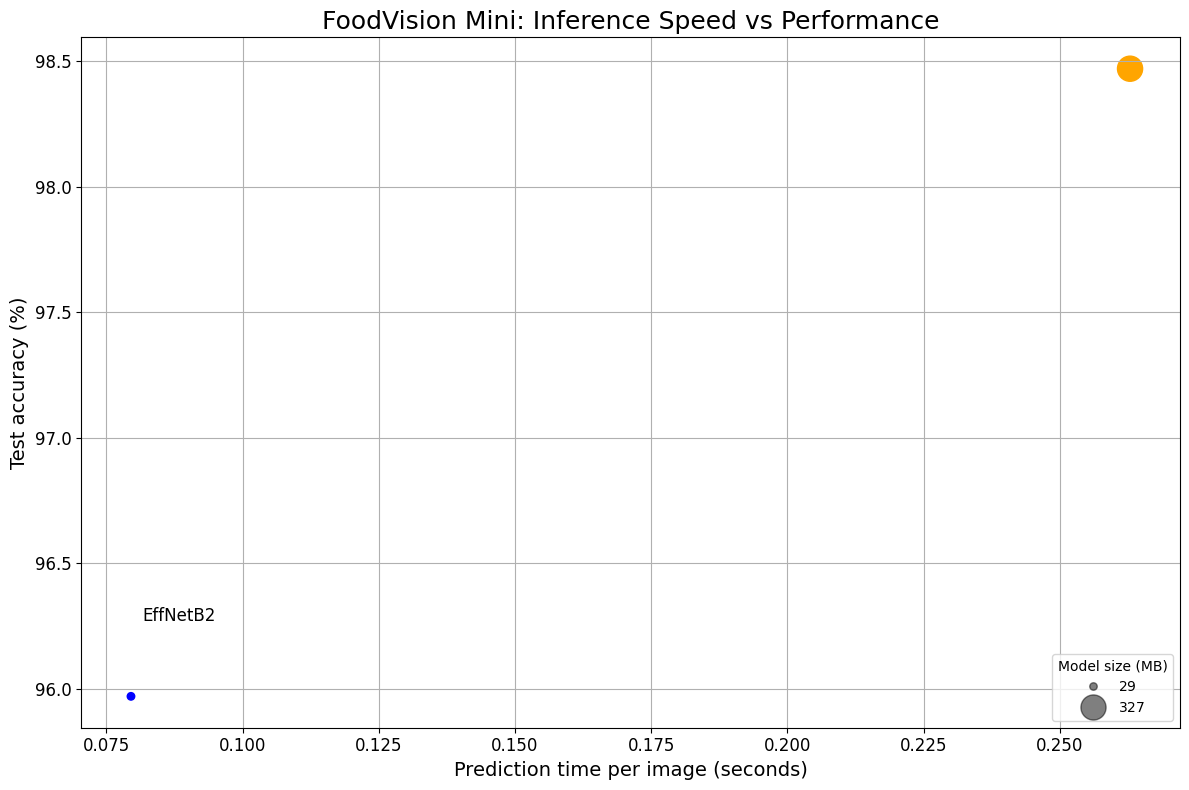

In [ ]:
# Create speed vs performance plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    data=df, 
    x="time_per_pred_cpu", 
    y="test_acc", 
    c=["blue", "orange"],
    s="model_size (MB)"  
)

ax.set_title("FoodVision Mini: Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# Annotate with model names
for index, row in df.iterrows():
    ax.annotate(
        text=row["model"],
        xy=(row["time_per_pred_cpu"] + 0.002, row["test_acc"] + 0.3),
        fontsize=12
    )

# Create legend for model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
ax.legend(handles, labels, loc="lower right", title="Model size (MB)", fontsize=10)

plt.tight_layout()
plt.show()

## 7. Conclusion: Which Model to Deploy?

The visualization shows the **speed vs. performance tradeoff** clearly:

- **ViT** has slightly better accuracy but is much larger and slower
- **EffNetB2** is smaller, faster, and still achieves excellent accuracy

For our FoodVision Mini deployment goals:
1. **Performance**: Both models achieve 95%+ accuracy ✓
2. **Speed**: EffNetB2 is significantly faster ✓

**Our choice: EffNetB2**

Since we're deploying to devices with limited resources (mobile phones, web browsers), the smaller model size and faster inference time of EffNetB2 make it the better choice. The small difference in accuracy is far outweighed by the benefits of:
- 11x smaller model size (~29 MB vs ~327 MB)
- 2-5x faster predictions
- Lower memory requirements

> **Note:** The "best" model depends entirely on your deployment constraints. If you had unlimited compute power and accuracy was the only concern, ViT might be preferable. Always consider where your model will run!

## Key Takeaways

- **Model deployment** brings ML models from experimentation to real-world use
- **Feature extractors** leverage transfer learning for efficient training
- **Transfer learning** freezes pretrained base layers and only trains the classifier head
- **Model size matters** for deployment - smaller models are faster and more portable
- **Speed vs. performance tradeoff** is a key consideration when choosing models
- **EffNetB2** provides an excellent balance of accuracy, speed, and size
- **ViT** achieves great accuracy but at the cost of larger size and slower inference
- Always **test on your target hardware** to understand real-world performance